In [1]:
import pandas as pd
read=pd.read_csv('/home/hyuksu/projects/ml/project/데이터/FIN_DATA_v2.csv',encoding='utf-8')
read

,DATE_YM,STATES,SIZE,PRICE_MEDIAN,COUNTS,CPI,BASE_RATE,CPI_YOY,REAL_RATE,HOUSE_RATE,VARIABLED
0,201504,강남구,대형,128750.0,246,94.625,1.730,0.436241,1.293759,2.81,0.969868
1,201505,강남구,대형,133000.0,204,94.890,1.740,0.552088,1.187912,3.06,1.064000
2,201506,강남구,대형,131000.0,183,94.909,1.570,0.701341,0.868659,3.01,1.007692
3,201507,강남구,대형,139250.0,176,95.080,1.480,0.735279,0.744721,2.96,1.081553
4,201508,강남구,대형,135000.0,157,95.213,1.490,0.700151,0.789849,2.94,1.015038
...,...,...,...,...,...,...,...,...,...,...,...
4567,202506,중구,중형,120000.0,86,116.310,2.520,2.169712,0.350288,3.93,0.960000
4568,202507,중구,중형,115000.0,20,116.520,2.500,2.094103,0.405897,3.96,0.958333
4569,202508,중구,중형,129000.0,25,116.450,2.506,1.667540,0.838460,3.96,0.959108
4570,202509,중구,중형,137500.0,69,117.060,2.526,2.102050,0.423950,3.96,1.145833


In [19]:
import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# 1) 데이터 준비
# -------------------------
df = read.copy()
df["DATE_YM"] = df["DATE_YM"].astype(int)

# 타깃
y_col = "VARIABLED"

# (선택) 거래량 로그: 분포가 치우친 경우 성능 좋아지는 경우 많음
df["COUNTS_LOG"] = np.log1p(df["COUNTS"])

# SIZE는 순서형으로도 가능하지만, (A)에서는 일단 One-Hot로 간다
num_features = ["PRICE_MEDIAN", "COUNTS_LOG", "CPI_YOY", "REAL_RATE", "HOUSE_RATE"]
cat_features = ["STATES", "SIZE"]

# 결측 제거
df = df.dropna(subset=[y_col] + num_features + cat_features)

# 정렬 (시계열 안전)
df = df.sort_values("DATE_YM").reset_index(drop=True)

# -------------------------
# 2) 시간 기준 split
#    (원하면 날짜 컷 조정해도 됨)
# -------------------------
train = df[df["DATE_YM"] <= 202112]
valid = df[(df["DATE_YM"] >= 202201) & (df["DATE_YM"] <= 202212)]
test  = df[df["DATE_YM"] >= 202301]

X_train, y_train = train[num_features + cat_features], train[y_col]
X_valid, y_valid = valid[num_features + cat_features], valid[y_col]
X_test,  y_test  = test[num_features + cat_features],  test[y_col]

print("rows:", len(train), len(valid), len(test))

# -------------------------
# 3) 전처리: 숫자 그대로 + 범주 One-Hot
# -------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("num", "passthrough", num_features),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_features),
    ],
    remainder="drop"
)

# -------------------------
# 4) 모델: Ridge (선형 + 정규화)
# -------------------------
ridge = Ridge(alpha=1.5, random_state=42)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", ridge)
])

# -------------------------
# 5) 학습
# -------------------------
model.fit(X_train, y_train)

# -------------------------
# 6) 평가 함수
# -------------------------
def eval_reg(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"[{name}] MAE={mae:.6f}  RMSE={rmse:.6f}  R2={r2:.6f}")

# 검증/테스트 성능
pred_valid = model.predict(X_valid)
pred_test  = model.predict(X_test)

eval_reg("VALID", y_valid, pred_valid)
eval_reg("TEST ", y_test,  pred_test)
print(f'R2_CORE:{model.score(X_test, y_test)}')
from sklearn.metrics import mean_absolute_error
import numpy as np

y_mean = np.full_like(y_valid, y_train.mean())
print("Mean baseline MAE:", mean_absolute_error(y_valid, y_mean))
print("Ridge MAE:", mean_absolute_error(y_valid, pred_valid))


rows: 2916 432 1224
[VALID] MAE=0.259996  RMSE=0.449242  R2=0.072083
[TEST ] MAE=0.243053  RMSE=0.395292  R2=-0.177961
R2_CORE:-0.17796060052309937
Mean baseline MAE: 0.2847498090310856
Ridge MAE: 0.25999589801555195


In [5]:
# 전처리 후 feature 이름 뽑기
ohe = model.named_steps["prep"].named_transformers_["cat"]
cat_names = ohe.get_feature_names_out(["STATES","SIZE"])
feature_names = num_features + list(cat_names)

coefs = model.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs}).sort_values("coef")

# 영향 큰 것 상/하 15개 보기
print(coef_df.head(15))
print(coef_df.tail(15))


         feature      coef
2        CPI_YOY -0.046273
0   PRICE_MEDIAN  0.000002
3      REAL_RATE  0.005821
1     COUNTS_LOG  0.021323
10    STATES_서초구  0.058082
17       SIZE_중형  0.063223
4     HOUSE_RATE  0.087825
11    STATES_송파구  0.090980
13    STATES_용산구  0.102970
16       SIZE_소형  0.147868
7     STATES_광진구  0.153421
12    STATES_양천구  0.162729
5     STATES_강서구  0.174205
8     STATES_노원구  0.185542
15     STATES_중구  0.185678
       feature      coef
1   COUNTS_LOG  0.021323
10  STATES_서초구  0.058082
17     SIZE_중형  0.063223
4   HOUSE_RATE  0.087825
11  STATES_송파구  0.090980
13  STATES_용산구  0.102970
16     SIZE_소형  0.147868
7   STATES_광진구  0.153421
12  STATES_양천구  0.162729
5   STATES_강서구  0.174205
8   STATES_노원구  0.185542
15   STATES_중구  0.185678
6   STATES_관악구  0.193073
9   STATES_도봉구  0.213846
14  STATES_종로구  0.230305


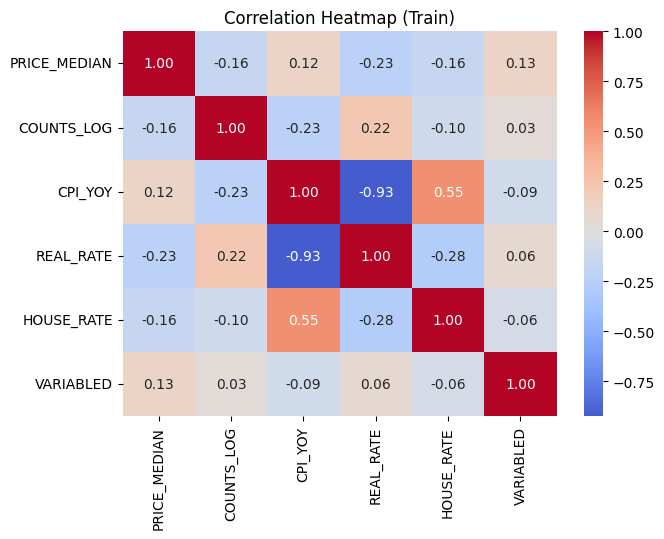

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ["PRICE_MEDIAN","COUNTS_LOG","CPI_YOY","REAL_RATE","HOUSE_RATE","VARIABLED"]

corr = train[num_cols].corr()  # train 기준 추천(미래누수 방지)

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Train)")
plt.show()


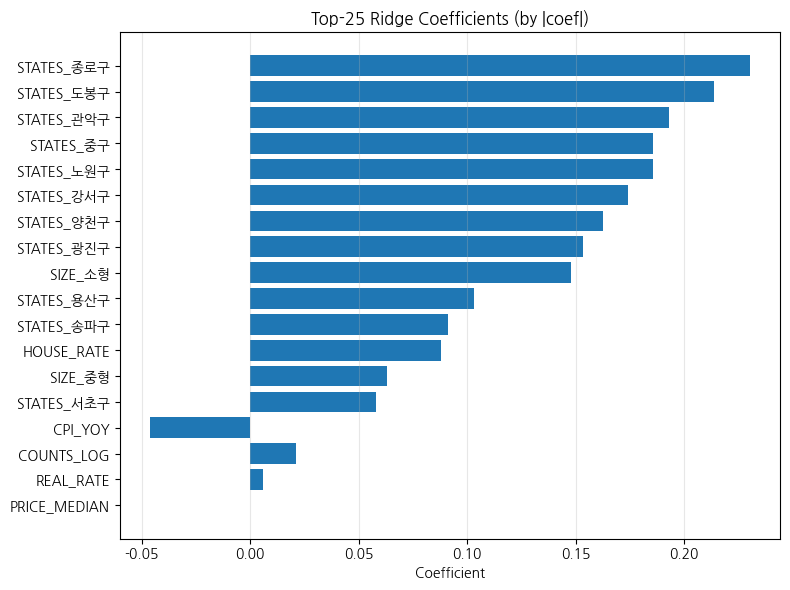

,feature,coef,abs
14,STATES_종로구,0.230305,0.230305
9,STATES_도봉구,0.213846,0.213846
6,STATES_관악구,0.193073,0.193073
15,STATES_중구,0.185678,0.185678
8,STATES_노원구,0.185542,0.185542
5,STATES_강서구,0.174205,0.174205
12,STATES_양천구,0.162729,0.162729
7,STATES_광진구,0.153421,0.153421
16,SIZE_소형,0.147868,0.147868
13,STATES_용산구,0.102970,0.102970


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc



plt.rcParams['font.family'] = 'D2Coding'
plt.rcParams['axes.unicode_minus'] = False
rc('font', family='NanumGothic')
# 1) 전처리 후 feature 이름 복원
prep = model.named_steps["prep"]
ohe = prep.named_transformers_["cat"]

cat_names = ohe.get_feature_names_out(["STATES","SIZE"])
feature_names = num_features + list(cat_names)

# 2) 계수 추출
coefs = model.named_steps["model"].coef_
coef_df = pd.DataFrame({"feature": feature_names, "coef": coefs})
coef_df["abs"] = coef_df["coef"].abs()
coef_df = coef_df.sort_values("abs", ascending=False)

# 3) 상위 25개 시각화
topk = 25
plt.figure(figsize=(8,6))
plt.barh(coef_df.head(topk)["feature"][::-1], coef_df.head(topk)["coef"][::-1])
plt.title(f"Top-{topk} Ridge Coefficients (by |coef|)")
plt.xlabel("Coefficient")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# (원하면 전체 표 확인)
coef_df.head(50)


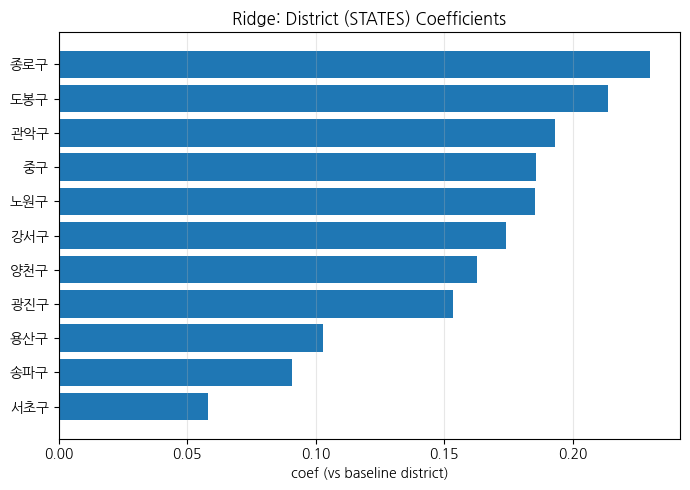

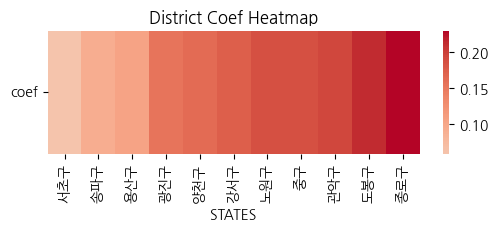

In [11]:
import re
import seaborn as sns
import matplotlib.pyplot as plt

# STATES 계수만 추출
states_df = coef_df[coef_df["feature"].str.startswith("STATES_")].copy()
states_df["STATES"] = states_df["feature"].str.replace("STATES_", "", regex=False)

# 막대그래프 (추천)
states_df = states_df.sort_values("coef")
plt.figure(figsize=(7,5))
plt.barh(states_df["STATES"], states_df["coef"])
plt.title("Ridge: District (STATES) Coefficients")
plt.xlabel("coef (vs baseline district)")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# (원하면 히트맵 형태로도 가능)
plt.figure(figsize=(6,1.6))
sns.heatmap(states_df.set_index("STATES")[["coef"]].T, cmap="coolwarm", center=0, annot=False)
plt.title("District Coef Heatmap")
plt.yticks(rotation=0)
plt.show()


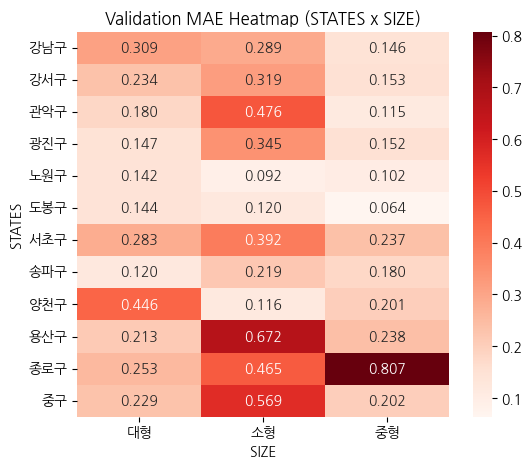

In [12]:
from sklearn.metrics import mean_absolute_error

# valid 예측
pred_valid = model.predict(X_valid)

valid_eval = valid.copy()
valid_eval["pred"] = pred_valid
valid_eval["abs_err"] = (valid_eval["pred"] - valid_eval["VARIABLED"]).abs()

# 구×사이즈 MAE
pivot_mae = valid_eval.pivot_table(
    index="STATES",
    columns="SIZE",
    values="abs_err",
    aggfunc="mean"
)

plt.figure(figsize=(6,5))
sns.heatmap(pivot_mae, annot=True, fmt=".3f", cmap="Reds")
plt.title("Validation MAE Heatmap (STATES x SIZE)")
plt.show()
